# SWIFT Random Forest Rainfall Retrieval

© Ben S. Pickering, last edited 2022-02-09.

This notebook demonstrates the application of the pre-trained Random Forest algorithm.

Input a time selection (15-minute intervals) and a rainfall map will be generated.

# 0. Imports and settings

In [1]:
import datetime
import satpy # Requires virtual environment for reading native (.nat) and hrit files.
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # py.proj flags warnings for empty SEVIRI pixels.
import SWIFT_RF_functions as RF # All the magic happens in here.

outdir = "/gws/nopw/j04/swift/bpickering/random_forest_precip/5_apply_model/RF_run_wavelets_v1/"

start = datetime.datetime.now()

Temporary Directory for Decompress: /work/scratch-nopw/bpickering/tmp/


# 1a. Find last SEVIRI file time

In [2]:
YYYY, MM, DD, hh, mm = RF.last_seviri()
print (YYYY, MM, DD, hh, mm)

2022 3 6 12 45


# 1b. Or manually select a desired time

In [3]:
YYYY, MM, DD, hh, mm = 2018, 6, 28, 15, 0

# 2. Import feature data

In [4]:
features = RF.import_feature_data_apply(
    date_time = datetime.datetime(YYYY, MM, DD, hh, mm) , 
    traindir = '/gws/nopw/j04/swift/bpickering/random_forest_precip/1_training_data/', 
    random = False, 
    solar = True, 
    seviri_diff = True, 
    topography = True,
    wavelets = True
)

adding SEVIRI channel features...
requested date/time = 2018-06-28 15:00:00
adding solar metadata features...
adding SEVIRI channel difference features...
adding pixel topography features...
adding wavelet features...
Wavelet length scales: ['30.0', '37.8', '47.6', '60.0', '75.6', '95.2', '120.0', '151.2', '190.5', '240.0', '302.4']
done!
The shape of the features array is: (62845, 40)
The size of the features array is: 0.020 GB.



# 3. Load pre-trained Random Forest, feed it features

In [5]:
# Path to the pre-trained RF model
#modelpath = '/gws/nopw/j04/swift/bpickering/random_forest_precip/3_training_model/RF_models/RF_model___short_seviri_diff_all___201501-201912_all_0.1perc___bins_0-0.5-2-5-10-20-35-60-100-200__est100_balanced_subsample_gini_maxfeatNone_minsplit0.001_maxdepthNone_bootstrap_0.01_time-20220118-2153.pkl'
modelpath = ('/gws/nopw/j04/swift/bpickering/random_forest_precip/3_training_model/RF_models/'
             + 'RF_model___base_seviri_plus_diff_plus_topog_plus_wavelets___'
             + '201501-201912_all_5.0perc___bins_0-0.5-2-5-10-20-35-60-100-200__'
             + 'est100_balanced_subsample_gini_maxfeat4_minsplit5_maxdepth10_bootstrap_0.0001_'
             + 'time-20220304-1912.pkl')
# Apply the RF to the loaded features
RF_predictions = RF.apply_model(modelpath=modelpath, features=features)

# Change the classes into precipitation rate
boundaries = ['0','0.5','2','5','10','20','35','60','100','200']
bin_edges, bin_values, bin_labels = RF.create_bin_values_and_labels(boundaries)
RF_predictions = RF.precip_bin_values(RF_predictions, bin_values)

# Turn 1D data into a square array (map)
precip_data = RF.generate_map(np.array(features), RF_predictions)

['MSG_13.4-10.8', 'MSG_7.3-10.8', 'MSG_6.2-7.3', 'MSG_9.7', 'MSG_3.9', 'Longitude', 'MSG_3.9-10.8', 'Solar_azimuth_sin', 'Solar_elevation', 'w_120.0', 'Latitude', 'w_30.0', 'w_60.0', 'prominence']


# 4. Plot the results

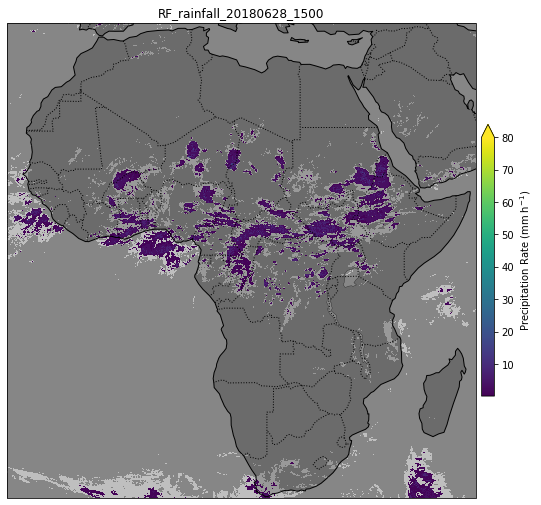

In [6]:
RF.plot_rainfall(
    YYYY, MM, DD, hh, mm, 
    precip_data, 
    precip_mask=RF.mask_binary(precip_data), 
    origin='RF',
    outdir=outdir
)

In [7]:
# Statistics about runtime (only fair when "Run all cells" used)
end = datetime.datetime.now()
time_taken = end-start
print("Time taken:", time_taken)

Time taken: 0:01:11.384126
